# US News World Report Analysis

In [ ]:
import os

RPLIBHOME=os.getenv('RPLIBHOME')

In [2]:
exec(open('/config_dev.py').read())

Dataframes Available
Ds_df
datasets_df
hillside_cards_df
lop_cards_df


In [3]:
import pandas as pd

df_games = datasets_df.loc[(datasets_df['Type'] == 'Features') & (datasets_df['Dataset Name'].str.contains('US News'))]
df_games.set_index('Dataset ID',inplace=True)
df_games

,Dataset Name,Description,Type,Data provenance,Download links
Dataset ID,,,,,
19,US News and World Report,US News and World Report (Need years),Features,https://github.com/IGARDS/RPLib/blob/main/pipe...,https://raw.githubusercontent.com/IGARDS/us_ne...


## D Matrix Creation

In [4]:
years = [2002,2003,2004]
columns = ['columns1.txt','columns2.txt']
colleges = ['colleges1.txt']
for ix in df_games.index:
    for year in years:
        for columns_sel in columns:
            for colleges_sel in colleges:
                !python ../../pipelines/create_D_from_us_news_world_report.py {ix} {ix} {year} {colleges_sel} {columns_sel}

test
test
test
^C
Traceback (most recent call last):
  File "../../pipelines/create_D_from_us_news_world_report.py", line 12, in <module>
    from ranking_toolbox import pyrankability
  File "/home/jupyter-pander14/ranking_toolbox/pyrankability/__init__.py", line 5, in <module>
    from . import plot
  File "/home/jupyter-pander14/ranking_toolbox/pyrankability/plot.py", line 1, in <module>
    import matplotlib.pyplot as plt
  File "/opt/tljh/user/lib/python3.7/site-packages/matplotlib/pyplot.py", line 36, in <module>
    import matplotlib.colorbar
  File "/opt/tljh/user/lib/python3.7/site-packages/matplotlib/colorbar.py", line 44, in <module>
    import matplotlib.contour as contour
  File "/opt/tljh/user/lib/python3.7/site-packages/matplotlib/contour.py", line 17, in <module>
    import matplotlib.text as text
  File "/opt/tljh/user/lib/python3.7/site-packages/matplotlib/text.py", line 1241, in <module>
    docstring.interpd.update(Text=artist.kwdoc(Text))
  File "/opt/tljh/user/lib/

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

from IPython.display import Image
def draw(A):
    return Image(A.draw(format='png', prog='dot'))

In [4]:
import sys
from pathlib import Path
home = str(Path.home())

sys.path.insert(0,"%s/ranking_toolbox"%home)
sys.path.insert(0,"%s/RPLib"%home)

In [5]:
import pyrankability

In [6]:
import pyrplib

In [7]:
years = [2002,2003,2004]

In [8]:
colleges = """
Amherst College
Bowdoin College
Carleton College
Claremont McKenna College
Davidson College
Haverford College
Middlebury College
Pomona College
Swarthmore College
Wellesley College
Williams College
""".strip().split('\n')
colleges

['Amherst College',
 'Bowdoin College',
 'Carleton College',
 'Claremont McKenna College',
 'Davidson College',
 'Haverford College',
 'Middlebury College',
 'Pomona College',
 'Swarthmore College',
 'Wellesley College',
 'Williams College']

In [9]:
pd.Series(colleges)

0               Amherst College
1               Bowdoin College
2              Carleton College
3     Claremont McKenna College
4              Davidson College
5             Haverford College
6            Middlebury College
7                Pomona College
8            Swarthmore College
9             Wellesley College
10             Williams College
dtype: object

In [10]:
data = {}
for year in years:
    data[year] = pd.read_excel('data/USNews liberal arts 2002-2016 (1).xls',sheet_name=str(year))
    data[year]['School Name'] = data[year]['School Name'].str.replace('!','')
    if 'State' in data[year].columns:
        data[year]['State'] = data[year]['State'].str.replace('\(','').str.replace('\)','')
    df = pd.DataFrame(list(data[year]['SAT/ACT 25th-75th Percentile'].str.split('-')),columns=['SAT/ACT 25th Percentile','SAT/ACT 75th Percentile'])
    data[year] = pd.concat([data[year],df],axis=1)
    data[year] = data[year].infer_objects()
    data[year]['SAT/ACT 25th-75th Percentile Mean'] = (data[year]['SAT/ACT 25th Percentile'].astype(int)+data[year]['SAT/ACT 75th Percentile'].astype(int))/2


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [11]:
data2 = {}
for year in years:
    data2[year] = data[year].set_index('School Name')
    data2[year] = data2[year].loc[colleges]

### Now select the year you want to process

In [12]:
year = 2002

In [13]:
student_columns = {}
parent_columns = {}

In [14]:
columns = list(data[year].columns)
student_columns[year] = [columns[13],columns[16],columns[22],columns[9],columns[11]]
student_columns[year]

['Selectivity Rank',
 'Acceptance Rate',
 'SAT/ACT 25th-75th Percentile Mean',
 'Percent of Classes with Less Than 20 Students',
 'Student/Faculty Ratio']

In [15]:
parent_columns[year] = [columns[6],columns[9],columns[11],columns[13],columns[16]]
parent_columns[year]

['Actual 6-year Graduation Rate',
 'Percent of Classes with Less Than 20 Students',
 'Student/Faculty Ratio',
 'Selectivity Rank',
 'Acceptance Rate']

In [16]:
set(parent_columns[year]).union(student_columns[year])

{'Acceptance Rate',
 'Actual 6-year Graduation Rate',
 'Percent of Classes with Less Than 20 Students',
 'SAT/ACT 25th-75th Percentile Mean',
 'Selectivity Rank',
 'Student/Faculty Ratio'}

Do we have all the colleges? 

In [17]:
assert sum(data[year]['School Name'].isin(colleges)) == len(colleges)

## Transform all the columns so they are the same direction as Final Rank column

In [18]:
from sklearn.pipeline import Pipeline
Ds = pd.DataFrame(columns=['Year','Group','D']).set_index(['Year','Group'])
parent_pipe = Pipeline([('fix_sign', pyrplib.transformers.ColumnDirectionTransformer('Final Rank')),
                        ('count_transformer', pyrplib.transformers.ColumnCountTransformer(parent_columns[year]))
                ])

student_pipe = Pipeline([('fix_sign', pyrplib.transformers.ColumnDirectionTransformer('Final Rank')),
                        ('count_transformer', pyrplib.transformers.ColumnCountTransformer(student_columns[year]))
                ])

both_columns = list(set(parent_columns[year]+student_columns[year]))

both_pipe = Pipeline([('fix_sign', pyrplib.transformers.ColumnDirectionTransformer('Final Rank')),
                        ('count_transformer', pyrplib.transformers.ColumnCountTransformer(both_columns))
                ])

parent_pipe.fit(data2[year])
D = parent_pipe.transform(data2[year])
Ds = Ds.append(pd.Series([D],index=['D'],name=(year,'Parent')))

student_pipe.fit(data2[year])
D = student_pipe.transform(data2[year])
Ds = Ds.append(pd.Series([D],index=['D'],name=(year,'Student')))

both_pipe.fit(data2[year])
D = both_pipe.transform(data2[year])
Ds = Ds.append(pd.Series([D],index=['D'],name=(year,'Both')))

In [19]:
Ds.loc[(year,'Both'),'D']

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,5.0,4.0,6.0,5.0,5.0,3.0,4.0,3.0,6.0,4.0
Bowdoin College,1.0,0.0,4.0,4.0,5.0,3.0,2.0,3.0,1.0,5.0,1.0
Carleton College,2.0,2.0,0.0,3.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0
Claremont McKenna College,0.0,2.0,3.0,0.0,4.0,4.0,1.0,3.0,0.0,4.0,1.0
Davidson College,1.0,1.0,3.0,2.0,0.0,1.0,2.0,2.0,1.0,4.0,1.0
Haverford College,1.0,3.0,4.0,2.0,5.0,0.0,3.0,2.0,2.0,6.0,2.0
Middlebury College,3.0,4.0,4.0,5.0,4.0,3.0,0.0,3.0,2.0,5.0,3.0
Pomona College,2.0,3.0,4.0,3.0,4.0,4.0,3.0,0.0,2.0,5.0,3.0
Swarthmore College,3.0,5.0,5.0,6.0,5.0,4.0,4.0,4.0,0.0,6.0,4.0


In [20]:
Ds.loc[(year,'Student'),'D']

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,4.0,3.0,5.0,4.0,4.0,2.0,3.0,2.0,5.0,3.0
Bowdoin College,1.0,0.0,3.0,3.0,5.0,3.0,1.0,2.0,1.0,4.0,1.0
Carleton College,2.0,2.0,0.0,2.0,3.0,2.0,1.0,1.0,1.0,3.0,2.0
Claremont McKenna College,0.0,2.0,3.0,0.0,4.0,4.0,1.0,2.0,0.0,4.0,1.0
Davidson College,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0
Haverford College,1.0,2.0,3.0,1.0,4.0,0.0,2.0,1.0,1.0,5.0,2.0
Middlebury College,3.0,4.0,4.0,4.0,4.0,3.0,0.0,2.0,2.0,5.0,3.0
Pomona College,2.0,3.0,4.0,3.0,4.0,4.0,3.0,0.0,2.0,5.0,3.0
Swarthmore College,3.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,0.0,5.0,4.0


In [21]:
Ds.loc[(year,'Parent'),'D']

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,4.0,3.0,5.0,4.0,4.0,3.0,4.0,3.0,5.0,4.0
Bowdoin College,1.0,0.0,4.0,4.0,4.0,2.0,2.0,3.0,1.0,4.0,1.0
Carleton College,2.0,1.0,0.0,3.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0
Claremont McKenna College,0.0,1.0,2.0,0.0,3.0,3.0,1.0,3.0,0.0,3.0,1.0
Davidson College,1.0,1.0,3.0,2.0,0.0,1.0,2.0,2.0,1.0,4.0,1.0
Haverford College,1.0,3.0,4.0,2.0,4.0,0.0,3.0,2.0,2.0,5.0,2.0
Middlebury College,2.0,3.0,3.0,4.0,3.0,2.0,0.0,3.0,2.0,4.0,2.0
Pomona College,1.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0,1.0,4.0,2.0
Swarthmore College,2.0,4.0,4.0,5.0,4.0,3.0,3.0,4.0,0.0,5.0,3.0


## Nearest and farthest from Centroid for combined columns, parent, and student

In [39]:
def update(details1,details2,init=True):
    for key in details1.keys():
        del details1[key]
    for key in details2.keys():
        details1[key] = details2[key]

details_columns = ['details_cont','details_bin','details_fixed_cont_x_maximize','details_fixed_cont_x_minimize','details_pair_maximize','details_pair_minimize']
for c in details_columns:
    Ds.loc[:,c] = [{} for _ in range(len(Ds))]
for index in Ds.index:
    D = Ds.loc[index,'D']
    delta_cont, details_cont = pyrankability.rank.solve(D,method='lop',cont=True)
    delta_bin, details_bin = pyrankability.rank.solve(D,method='lop',cont=False)
    Ds.loc[index,'delta_cont'] = delta_cont
    Ds.loc[index,'delta_bin'] = delta_bin
    update(Ds.loc[index,'details_cont'],details_cont)
    update(Ds.loc[index,'details_bin'],details_bin)
    _, details_fixed_cont_x_maximize = pyrankability.search.solve_fixed_cont_x(D,details_bin['obj'],details_cont['x'],method='lop',minimize=False)
    _, details_fixed_cont_x_minimize = pyrankability.search.solve_fixed_cont_x(D,details_bin['obj'],details_cont['x'],method='lop',minimize=True)    
    update(Ds.loc[index,'details_fixed_cont_x_maximize'],details_fixed_cont_x_maximize)
    update(Ds.loc[index,'details_fixed_cont_x_minimize'],details_fixed_cont_x_minimize)
    _, details_farthest_pair_maximize = pyrankability.search.solve_pair(D,method='lop',minimize=False)#,min_ndis=None,max_ndis=None,tau_range=None,lazy=False,verbose=True)
    update(Ds.loc[index,'details_pair_maximize'],details_farthest_pair_maximize)
    _, details_farthest_pair_minimize = pyrankability.search.solve_pair(D,method='lop',minimize=True, min_ndis=1)#,min_ndis=None,max_ndis=None,tau_range=None,lazy=False,verbose=True)
    update(Ds.loc[index,'details_pair_minimize'],details_farthest_pair_minimize)

import joblib
joblib.dump(Ds,"results/Ds.joblib.z");

Ds.reset_index().to_json('results/Ds.json',orient='records')

In [40]:
Ds

D  \
Year Group                                                        
2002 Parent                              Amherst College  Bo...   
     Student                             Amherst College  Bo...   
     Both                                Amherst College  Bo...   

                                                   details_cont  \
Year Group                                                        
2002 Parent   {'Pfirst': [(0, 8, 10, 6, 1, 5, 3, 7, 4, 9, 2)...   
     Student  {'Pfirst': [(8, 7, 6, 0, 10, 1, 3, 5, 2, 4, 9)...   
     Both     {'Pfirst': [(8, 0, 6, 10, 7, 1, 3, 5, 4, 2, 9)...   

                                                    details_bin  \
Year Group                                                        
2002 Parent   {'Pfirst': [(0, 8, 10, 6, 1, 3, 7, 5, 4, 9, 2)...   
     Student  {'Pfirst': [(8, 0, 7, 6, 10, 1, 3, 5, 2, 4, 9)...   
     Both     {'Pfirst': [(8, 0, 10, 7, 6, 1, 3, 5, 4, 9, 2)...   

                                  details_fixed_cont_x_maximize  \
Year Group                                                        
2002 Parent   {'obj': 2.069392454401895, 'perm': (0, 8, 10, ...   
     Student  {'obj': 1.3402902633048828, 'perm': (8, 6, 0, ...   
     Both     {'obj': 4.511336265842036, 'perm': (0, 8, 7, 1...   

                                  details_fixed_cont_x_minimize  \
Year Group                                                        
2002 Parent   {'obj': 1.9306075455598322, 'perm': (0, 8, 10,...   
     Student  {'obj': 1.3223645945944198, 'perm': (8, 7, 6, ...   
     Both     {'obj': 3.550433707154232, 'perm': (8, 0, 6, 1...   

                                          details_pair_maximize  \
Year Group                                                        
2002 Parent   {'obj': 4.0, 'k_x': 194.0, 'k_y': 194.0, 'perm...   
     Student  {'obj': 2.0, 'k_x': 203.0, 'k_y': 203.0, 'perm...   
     Both     {'obj': 9.0, 'k_x': 233.0, 'k_y': 233.0, 'perm...   

                                          details_pair_minimize  delta_cont  \
Year Group                                                                    
2002 Parent   {'obj': 4.0, 'k_x': 194.0, 'k_y': 194.0, 'perm...        83.0   
     Student  {'obj': 2.0, 'k_x': 203.0, 'k_y': 203.0, 'perm...        72.0   
     Both     {'obj': 1.0, 'k_x': 233.0, 'k_y': 233.0, 'perm...        97.0   

              delta_bin  
Year Group               
2002 Parent        81.0  
     Student       72.0  
     Both          97.0

In [27]:
closest_obj = Ds.loc[(year,'Both'),'details_fixed_cont_x_minimize']['obj']
farthest_obj = Ds.loc[(year,'Both'),'details_fixed_cont_x_maximize']['obj']
closest_obj,farthest_obj

(3.550433707154232, 4.511336265842036)

## Look at the continuous results

In [30]:
def plot_xstars(Ds,show_score_xstar2_func=lambda xstars: pyrankability.plot.show_score_xstar2(xstars,
                                                                     group_label="Group",width=300,height=300,
                                                                     columns=1,resolve_scale=True)):
    label = "A"
    xstars = {}
    for index in Ds.index:
        D = Ds.loc[index,'D']
        xstar = pd.DataFrame(Ds.loc[index,'details_cont']['x'],index=D.index,columns=D.columns)
        xstars["%s. %s"%(label,", ".join(str(v) for v in index[::-1]))] = xstar
        label = chr(ord(label)+1)
    g,score_df,ordered_xstars = show_score_xstar2_func(xstars)
    return g,score_df,ordered_xstars

In [31]:
g,_,_ = plot_xstars(Ds)
g

alt.FacetChart(...)

## Compare centroids for max and min for each group

In [32]:
pd.Series(Ds.loc[(year,'Both'),'D'].index)

0               Amherst College
1               Bowdoin College
2              Carleton College
3     Claremont McKenna College
4              Davidson College
5             Haverford College
6            Middlebury College
7                Pomona College
8            Swarthmore College
9             Wellesley College
10             Williams College
Name: School Name1, dtype: object

In [33]:
colleges

['Amherst College',
 'Bowdoin College',
 'Carleton College',
 'Claremont McKenna College',
 'Davidson College',
 'Haverford College',
 'Middlebury College',
 'Pomona College',
 'Swarthmore College',
 'Wellesley College',
 'Williams College']

In [34]:
Ds.loc[(year,'Parent'),'details_fixed_cont_x_minimize']['perm']

(0, 8, 10, 6, 1, 3, 7, 5, 4, 9, 2)

In [35]:
def perm_to_series(D,perm,name):
    return pd.Series(list(D.index[list(perm)]),name=name)

### Parent

In [36]:
A = perm_to_series(Ds.loc[(year,'Parent'),'D'],Ds.loc[(year,'Parent'),'details_fixed_cont_x_minimize'].perm,'Closest')
B = perm_to_series(Ds.loc[(year,'Parent'),'D'],Ds.loc[(year,'Parent'),'details_fixed_cont_x_maximize'].perm,'Farthest')
pyrankability.plot.spider2(A,B,file="results/parent_fixed_cont_x_minimize_maximize.png",xmult = 1.7,ymult=1.1)

AttributeError: 'dict' object has no attribute 'perm'

### Student

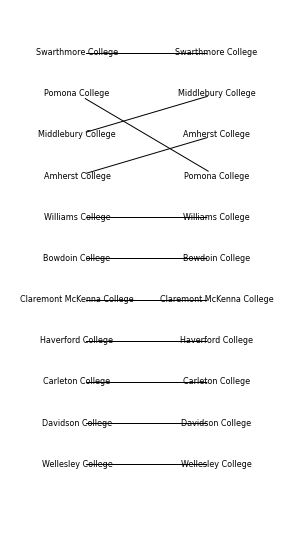

In [33]:
A = perm_to_series(Ds.loc[(year,'Student'),'D'],Ds.loc[(year,'Student'),'details_fixed_cont_x_minimize'].perm,'Closest')
B = perm_to_series(Ds.loc[(year,'Student'),'D'],Ds.loc[(year,'Student'),'details_fixed_cont_x_maximize'].perm,'Farthest')
pyrankability.plot.spider2(A,B,file="results/student_fixed_cont_x_minimize_maximize.png")

### Both

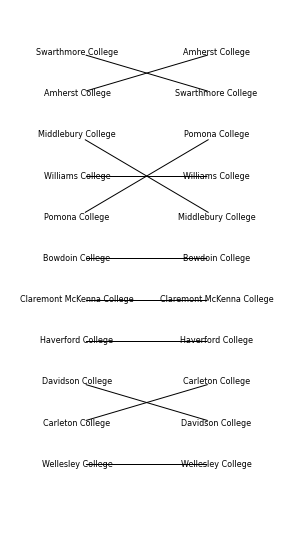

In [34]:
A = perm_to_series(Ds.loc[(year,'Both'),'D'],Ds.loc[(year,'Both'),'details_fixed_cont_x_minimize'].perm,'Closest')
B = perm_to_series(Ds.loc[(year,'Both'),'D'],Ds.loc[(year,'Both'),'details_fixed_cont_x_maximize'].perm,'Farthest')
pyrankability.plot.spider2(A,B,file="results/both_fixed_cont_x_minimize_maximize.png")

In [35]:
A

0            Swarthmore College
1               Amherst College
2            Middlebury College
3              Williams College
4                Pomona College
5               Bowdoin College
6     Claremont McKenna College
7             Haverford College
8              Davidson College
9              Carleton College
10            Wellesley College
Name: Closest, dtype: object

In [36]:
list(A)

['Swarthmore College',
 'Amherst College',
 'Middlebury College',
 'Williams College',
 'Pomona College',
 'Bowdoin College',
 'Claremont McKenna College',
 'Haverford College',
 'Davidson College',
 'Carleton College',
 'Wellesley College']

In [37]:
B

0               Amherst College
1            Swarthmore College
2                Pomona College
3              Williams College
4            Middlebury College
5               Bowdoin College
6     Claremont McKenna College
7             Haverford College
8              Carleton College
9              Davidson College
10            Wellesley College
Name: Farthest, dtype: object

In [38]:
list(B)

['Amherst College',
 'Swarthmore College',
 'Pomona College',
 'Williams College',
 'Middlebury College',
 'Bowdoin College',
 'Claremont McKenna College',
 'Haverford College',
 'Carleton College',
 'Davidson College',
 'Wellesley College']

### Now let's consider the centroid to a ranking of interest (Final rank)

In [39]:
data2[year]['Final Rank'].argsort()

School Name
Amherst College               0
Bowdoin College               8
Carleton College             10
Claremont McKenna College     9
Davidson College              1
Haverford College             2
Middlebury College            5
Pomona College                7
Swarthmore College            6
Wellesley College             4
Williams College              3
Name: Final Rank, dtype: int64

In [40]:
data2[year]['Final Rank']

School Name
Amherst College               1
Bowdoin College               5
Carleton College              5
Claremont McKenna College    17
Davidson College             10
Haverford College             5
Middlebury College            9
Pomona College                5
Swarthmore College            1
Wellesley College             4
Williams College              3
Name: Final Rank, dtype: int64

In [41]:
data2[year]['Final Rank'].iloc[data2[year]['Final Rank'].argsort()]

School Name
Amherst College               1
Swarthmore College            1
Williams College              3
Wellesley College             4
Bowdoin College               5
Carleton College              5
Haverford College             5
Pomona College                5
Middlebury College            9
Davidson College             10
Claremont McKenna College    17
Name: Final Rank, dtype: int64

In [42]:
perm_final_rank = data2[year]['Final Rank'].argsort()
x_final_rank = pyrankability.common.perm_to_x(perm_final_rank)

In [43]:
index = (year,'Student')
D = Ds.loc[index,'D']
delta_bin, details_bin = pyrankability.rank.solve(D,method='lop',cont=False)
_, details_fixed_binary_x_maximize = pyrankability.search.solve_fixed_binary_x(D,details_bin['obj'],x_final_rank,method='lop',minimize=False)
_, details_fixed_binary_x_minimize = pyrankability.search.solve_fixed_binary_x(D,details_bin['obj'],x_final_rank,method='lop',minimize=True)    

### Maximize (farthest)

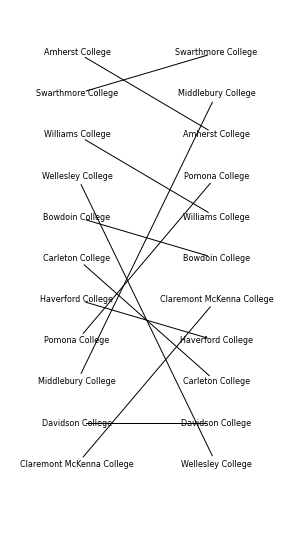

In [44]:
A = perm_to_series(D,perm_final_rank,'Final Rank')
B = perm_to_series(D,details_fixed_binary_x_maximize['perm'],'Farthest')
pyrankability.plot.spider2(A,B,file="results/student_details_fixed_binary_x_maximize.png")

### Minimize (closest)

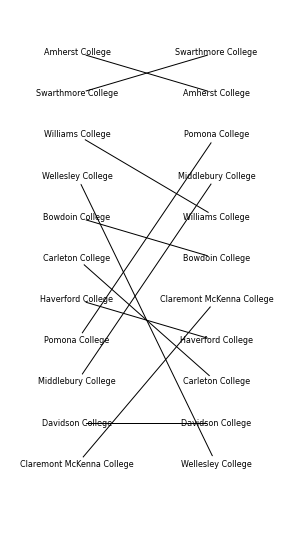

In [45]:
A = perm_to_series(D,perm_final_rank,'Final Rank')
B = perm_to_series(D,details_fixed_binary_x_minimize['perm'],'Closest')
pyrankability.plot.spider2(A,B,file="results/student_details_fixed_binary_x_minimize.png")

### Farthest pair

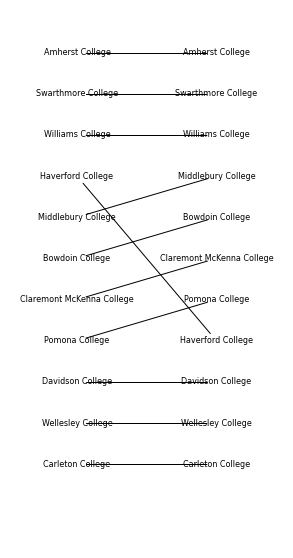

In [46]:
index = (year,'Parent')
D = Ds.loc[index,'D']
obj, farthest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=False)#,min_ndis=None,max_ndis=None,tau_range=None,lazy=False,verbose=True)

A = perm_to_series(D,farthest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_{index}.png')

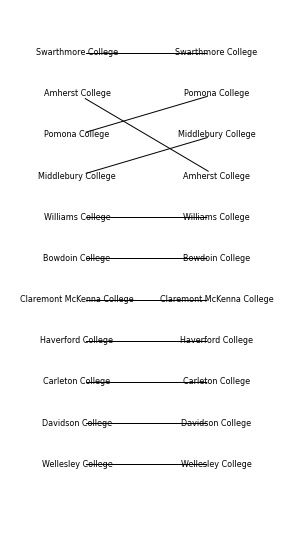

In [47]:
index = (year,'Student')
D = Ds.loc[index,'D']
obj, farthest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=False)#,min_ndis=None,max_ndis=None,tau_range=None,lazy=False,verbose=True)

A = perm_to_series(D,farthest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_{index}.png')

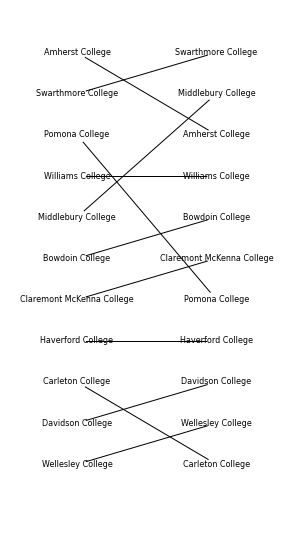

In [48]:
index = (year,'Both')
D = Ds.loc[index,'D']
obj, farthest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=False)#,min_ndis=None,max_ndis=None,tau_range=None,lazy=False,verbose=True)

A = perm_to_series(D,farthest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_{index}.png')

### Nearest pair

In [49]:
index = (year,'Both')
D = Ds.loc[index,'D']
obj, nearest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=True,min_ndis=1)

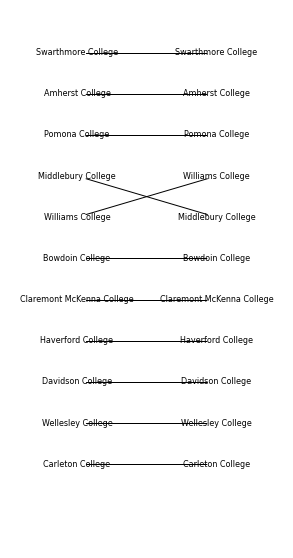

In [50]:
A = perm_to_series(D,nearest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,nearest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/nearest_pair_{index}.png')

## Two datasets farthest

In [51]:
index = (year,'Student')
D = Ds.loc[index,'D']
index2 = (year,'Parent')
D2 = Ds.loc[index2,'D']
obj, farthest_pair_details_D_D2 = pyrankability.search.solve_pair(D,D2=D2,method='lop',minimize=False)
obj

14.0

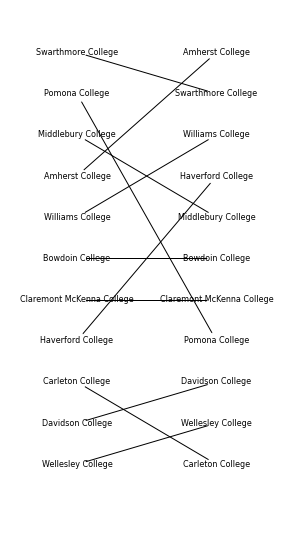

In [52]:
A = perm_to_series(D,farthest_pair_details_D_D2['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details_D_D2['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_{index}_{index2}.png')

### Student and parent nearest

In [53]:
index = (year,'Student')
D = Ds.loc[index,'D']
index2 = (year,'Parent')
D2 = Ds.loc[index2,'D']
obj, nearest_pair_details_D_D2 = pyrankability.search.solve_pair(D,D2=D2,method='lop',minimize=True)

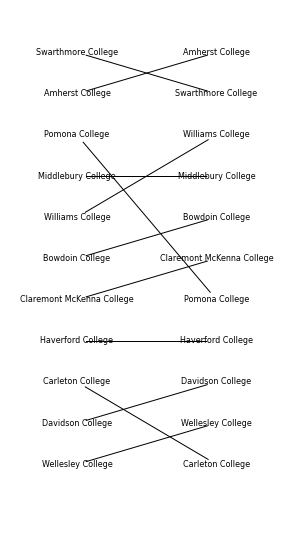

In [54]:
A = perm_to_series(D,nearest_pair_details_D_D2['perm_x'],'perm_x')
B = perm_to_series(D,nearest_pair_details_D_D2['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/nearest_pair_{index}_{index2}.png')

In [55]:
import joblib
joblib.dump(Ds,"results/Ds.joblib.z");

In [56]:
D = Ds.loc[(2002,'Both'),'D']
D

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,5.0,4.0,6.0,5.0,5.0,3.0,4.0,3.0,6.0,4.0
Bowdoin College,1.0,0.0,4.0,4.0,5.0,3.0,2.0,3.0,1.0,5.0,1.0
Carleton College,2.0,2.0,0.0,3.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0
Claremont McKenna College,0.0,2.0,3.0,0.0,4.0,4.0,1.0,3.0,0.0,4.0,1.0
Davidson College,1.0,1.0,3.0,2.0,0.0,1.0,2.0,2.0,1.0,4.0,1.0
Haverford College,1.0,3.0,4.0,2.0,5.0,0.0,3.0,2.0,2.0,6.0,2.0
Middlebury College,3.0,4.0,4.0,5.0,4.0,3.0,0.0,3.0,2.0,5.0,3.0
Pomona College,2.0,3.0,4.0,3.0,4.0,4.0,3.0,0.0,2.0,5.0,3.0
Swarthmore College,3.0,5.0,5.0,6.0,5.0,4.0,4.0,4.0,0.0,6.0,4.0


In [59]:
_,details_lop_with_models = pyrankability.rank.solve(D,method='lop',include_model=True)
model = details_lop_with_models['model']
model_file = pyrankability.common.write_model(model)
solution_file = model_file + ".solutions"
!sed -i '/^OBJSENS/d' $model_file
!$home/ranking_toolbox/collect.sh "$model_file" "$solution_file"

opt_k = details_lop_with_models['obj']

solutions = pd.read_csv(solution_file,sep=', ')
x_columns = solutions.columns[1:-1]
xs = []
a,b,c = 1,1,-2*len(x_columns)
n = int((-b + np.sqrt(b**2 - 4*a*c))/(2*a) + 1)
xstar = np.zeros((n,n))
objs = []
s = 0
for k in range(solutions.shape[0]):
    x = np.zeros((n,n))
    for c in x_columns:
        ij_str = c.replace("x(","").replace(")","")
        i,j = ij_str.split(",")
        i,j = int(i),int(j)
        x[i,j] = solutions.loc[k,c]
        x[j,i] = 1 - x[i,j]
    obj = np.sum(np.sum(D*x))
    xs.append(x)
    objs.append(obj)
    error = obj - opt_k
    xstar += x
xstar = xstar/solutions.shape[0]

perms = []
for x in xs:
    r = np.sum(x,axis=0)
    perm = np.argsort(r)
    perms.append(perm)

Model file: /tmp/tmpmjk7m79y/model.mps
Solutions file: /tmp/tmpmjk7m79y/model.mps.solutions
SCIP version 7.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 5.0.0] [GitHash: 0bc4dc9c65]
Copyright (C) 2002-2020 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  SoPlex 5.0.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 6535a3c8]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.2.0            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.9          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  PaPILO 1.0.0         parallel presolve for integer and linear optimization (https://github.com/lgottwald/PaPILO) [GitHash: 471d13d]
  bliss 0.73

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [60]:
from scipy import stats
taus = {} #np.zeros((len(perms),len(perms)))
for i in range(len(perms)):
    key = tuple(perms[i])
    taus[key] = []
    for j in range(len(perms)):
        tau,pvalue = stats.kendalltau(np.argsort(perms[i]), np.argsort(perms[j]))
        taus[key].append(tau)

In [61]:
taus_df = pd.DataFrame(columns=range(len(perms)))
for i in range(len(perms)):
    key = tuple(perms[i])
    taus_df = taus_df.append(pd.Series(taus[key],name=key))

In [62]:
taus_df

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
"(8, 0, 10, 7, 6, 1, 3, 5, 4, 9, 2)",1.000000,0.963636,0.963636,0.927273,0.963636,0.927273,0.927273,0.890909,0.927273,0.890909,...,0.818182,0.890909,0.854545,0.854545,0.818182,0.818182,0.781818,0.854545,0.890909,0.854545
"(0, 8, 10, 7, 6, 1, 3, 5, 4, 9, 2)",0.963636,1.000000,0.927273,0.963636,0.927273,0.963636,0.890909,0.927273,0.890909,0.927273,...,0.854545,0.927273,0.890909,0.890909,0.854545,0.854545,0.818182,0.818182,0.854545,0.890909
"(8, 0, 7, 10, 6, 1, 3, 5, 4, 9, 2)",0.963636,0.927273,1.000000,0.963636,0.927273,0.890909,0.890909,0.854545,0.963636,0.927273,...,0.781818,0.854545,0.818182,0.818182,0.781818,0.854545,0.818182,0.890909,0.927273,0.890909
"(0, 8, 7, 10, 6, 1, 3, 5, 4, 9, 2)",0.927273,0.963636,0.963636,1.000000,0.890909,0.927273,0.854545,0.890909,0.927273,0.963636,...,0.818182,0.890909,0.854545,0.854545,0.818182,0.890909,0.854545,0.854545,0.890909,0.927273
"(8, 0, 10, 7, 6, 1, 3, 5, 4, 2, 9)",0.963636,0.927273,0.927273,0.890909,1.000000,0.963636,0.963636,0.927273,0.963636,0.927273,...,0.781818,0.927273,0.890909,0.890909,0.854545,0.854545,0.818182,0.818182,0.854545,0.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(0, 8, 6, 7, 10, 1, 3, 5, 4, 2, 9)",0.818182,0.854545,0.854545,0.890909,0.854545,0.890909,0.818182,0.854545,0.890909,0.927273,...,0.854545,0.927273,0.890909,0.963636,0.927273,1.000000,0.963636,0.890909,0.927273,0.963636
"(0, 8, 6, 7, 10, 1, 3, 5, 2, 4, 9)",0.781818,0.818182,0.818182,0.854545,0.818182,0.854545,0.854545,0.890909,0.854545,0.890909,...,0.818182,0.890909,0.927273,0.927273,0.963636,0.963636,1.000000,0.854545,0.890909,0.927273
"(8, 6, 0, 7, 10, 1, 3, 5, 4, 9, 2)",0.854545,0.818182,0.890909,0.854545,0.818182,0.781818,0.781818,0.745455,0.854545,0.818182,...,0.818182,0.818182,0.781818,0.854545,0.818182,0.890909,0.854545,1.000000,0.963636,0.927273
"(8, 0, 6, 7, 10, 1, 3, 5, 4, 9, 2)",0.890909,0.854545,0.927273,0.890909,0.854545,0.818182,0.818182,0.781818,0.890909,0.854545,...,0.854545,0.854545,0.818182,0.890909,0.854545,0.927273,0.890909,0.963636,1.000000,0.963636


In [63]:
taus_df.values[np.where(taus_df == 1)] = np.NaN

In [64]:
closest = Ds.loc[(year,'Both'),'details_fixed_cont_x_minimize'].perm
farthest = Ds.loc[(year,'Both'),'details_fixed_cont_x_maximize'].perm

In [65]:
source = taus_df.loc[[closest,farthest]]
source.index=['Closest','Farthest']
source = source.reset_index().melt(id_vars=['index'])
source.columns = ["Solution","To","Tau"]
source['pct'] = 1/len(source)
source

,Solution,To,Tau,pct
0,Closest,0,0.890909,0.006944
1,Farthest,0,0.854545,0.006944
2,Closest,1,0.854545,0.006944
3,Farthest,1,0.890909,0.006944
4,Closest,2,0.854545,0.006944
...,...,...,...,...
139,Farthest,69,0.781818,0.006944
140,Closest,70,0.927273,0.006944
141,Farthest,70,0.818182,0.006944
142,Closest,71,0.890909,0.006944


In [66]:
import altair as alt 
source2 = taus_df.loc[[closest,farthest]]
source2.index=['Closest','Farthest']
source2.T

g = alt.Chart(source2.T).mark_point().encode(
        x=alt.X('Closest:Q'),
        y=alt.Y('Farthest:Q')
    )
g

alt.Chart(...)

In [67]:
import altair as alt
g = alt.Chart(source).mark_area(
        opacity=0.6,
        interpolate='step'
    ).encode(
        x=alt.X('Tau:Q', bin=alt.Bin(maxbins=100)),
        y=alt.Y('sum(pct):Q', axis=alt.Axis(format='%'),stack=None,title='Percentage'),
        color=alt.Color('Solution:N')
    )
g

alt.Chart(...)

In [68]:
import altair as alt
g = alt.Chart(source).mark_area(
        opacity=0.6,
        interpolate='step'
    ).encode(
        x=alt.X('Tau:Q', bin=alt.Bin(maxbins=100)),
        y=alt.Y('sum(pct):Q', axis=alt.Axis(format='%'),stack=None,title='Percentage'),
        color=alt.Color('Solution:N')
    )
g

alt.Chart(...)

In [69]:
len(perms)

72